In [6]:
from collections import defaultdict
from __future__ import print_function

import copy
import os
import itertools
import operator
import logging
import pickle
import random
import sys
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
% matplotlib inline

/Users/kunal/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [20]:
# Logging level
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()

# Environment Parameters
GRID_HEIGHT = 9 
GRID_WIDTH = 6
START = (1,1)
GOAL1 = (GRID_WIDTH, GRID_HEIGHT)
GOALS = [GOAL1]
CLIFF_STATES = [(1,3), (3,7), (5,6)]
ACTIONS = [
    (0, 1),   #UP
    (0, -1),  #DOWN
    (1, 0),   #RIGHT
    (-1, 0),  #LEFT
#     (1, 1),   #NORTH_EAST
#     (-1, 1),  #NORTH_WEST
#     (1, -1),  #SOUTH_EAST
#     (-1, -1)  #SOUTH_WEST
]
ACTION_PLOT = {
    (0, 1) : u'\u2191',
    (0, -1) : u'\u2193',
    (1, 0) : u'\u2192',
    (-1, 0) : u'\u2190',
#     (1, 1) : u'\u2197',
#     (-1, 1) :  u'\u2196',
#     (1, -1) :  u'\u2198',
#     (-1, -1) : u'\u2199',
    None : '-'
}
STATE_LISTS = [range(1, GRID_WIDTH + 1), range(1, GRID_HEIGHT + 1)]
STATES = list(itertools.product(*STATE_LISTS))
# Flag to control whether planning should use observed actions
USE_OBSERVED_ACTIONS = True
PLANNING_STEPS = 10
WIND_PROBABILITY = 0.1
FALL_PENALTY = -100
TIME_PENALTY = -1
GOAL_REWARD = 100
NUM_EPISODES = 100000
EPSILON = 0.1
ALPHA = 0.1
GAMMA = 0.95

In [15]:
def is_valid_state(state):
    x, y = state[0], state[1]
    return x in range(1, GRID_WIDTH + 1) and y in range(1, GRID_HEIGHT + 1)

def is_start_state(state):
    assert is_valid_state(state)
    return state == START

def is_goal_state(state):
    assert is_valid_state(state)
    return state in GOALS

def is_cliff_state(state):
    assert is_valid_state(state)
    return state in CLIFF_STATES

def is_terminal_state(state):
    assert is_valid_state(state)
    return is_goal_state(state) or is_cliff_state(state)

# NOTE : This can return invalid states if action is invalid.
def get_next_state(state, action):
    if is_terminal_state(state):
        return state
    return tuple(map(operator.add, state, action))

def get_valid_actions(state):
    # There are no actions in terminal states. We return all actions since reward for terminal states is 0
    # and get_next_state is designed to not make any transitions in terminal states.
    if is_terminal_state(state):
        return ACTIONS
    valid_actions = []
    for action in ACTIONS:
        if is_valid_state(get_next_state(state, action)):
            valid_actions.append(action)
    return valid_actions 

def act(state, action, rt_action):
    assert not is_terminal_state(state)
    if random.random() < WIND_PROBABILITY:
        chosen_action = rt_action
    else:
        chosen_action = action
    next_state = get_next_state(state, chosen_action)
    if is_cliff_state(next_state):
        reward = FALL_PENALTY
    elif is_goal_state(next_state):
        reward = GOAL_REWARD
    else:
        reward = TIME_PENALTY
    # NOTE: Red Team reward is negative of agent reward
    return next_state, reward, -reward

def init_q(Q):
    for state in STATES:
        valid_actions = get_valid_actions(state)
        for action in valid_actions:
            next_state = get_next_state(state, action)
            if is_valid_state(next_state):
                Q[state][action] = 0

In [16]:
def get_random_action(state):
    # For non-terminal states there is atleast one valid action.
    # For terminal states it doesn't matter what action we return since all have reward 0.    
    valid_actions = get_valid_actions(state)
    assert len(valid_actions) > 0
    return random.choice(valid_actions)

def get_greedy_action(Q, state):
    return max(Q[state], key=Q[state].get)

def get_epsilon_greedy_action(Q, state):
    # Choose an exploratory action with probability epsilon
    if random.random() < EPSILON:
#         print('Returning Random Choice')
        return get_random_action(state)
    # Return greedy action
    return get_greedy_action(Q, state)

def get_optimal_policy(Q, state):
    optimal_policy = {} 
    visited = {}
    while not is_terminal_state(state):
        optimal_action = get_greedy_action(Q, state)
        optimal_policy[state] = optimal_action
        visited[state] = True
        state = get_next_state(state, optimal_action)
        if state in visited:
            break
    return optimal_policy

def plot_policy(policy):
    for y in reversed(xrange(1, GRID_HEIGHT + 1)):
        print('')
        for x in xrange(1, GRID_WIDTH + 1):
            state = (x,y)
            if is_start_state(state):
                char = 'S'
            elif is_goal_state(state):
                if state == GOAL1:
                    char = 'G'
                else:
                    char = 'G2'
            elif is_cliff_state(state):
                char = 'X'
            else:
                action = policy[state] if state in policy else None
                char = (ACTION_PLOT[action])
            print('%s   ' %(char), end='')
            
def plot_rt_policy(rt_Q):
    for y in reversed(xrange(1, GRID_HEIGHT + 1)):
        print('')
        for x in xrange(1, GRID_WIDTH + 1):
            state = (x,y)
            if is_cliff_state(state):
                char = 'X'
            elif is_goal_state(state):
                char = 'G'
            else:
                action = get_greedy_action(rt_Q, state)
                char = (ACTION_PLOT[action])
            print('%s   ' %(char), end='')

def get_smoothed_list(list_to_smooth, window_size = 50):
    num_episodes = len(list_to_smooth)
    smoothed_list = []
    cur_sum = sum(list_to_smooth[:window_size])
    smoothed_list.append(cur_sum * 1.0 / window_size)
    for i in xrange(window_size, num_episodes):
        cur_sum -= list_to_smooth[i-window_size]
        cur_sum += list_to_smooth[i]
        smoothed_list.append(cur_sum * 1.0 / window_size)
    return smoothed_list

def plot_lists(lists, legend_labels, xlabel, ylabel, smoothed=True, log_scale=True):
    for l in lists:
        if smoothed:
            l = get_smoothed_list(l)
        if log_scale:
            plt.semilogy(l)
        else:
            plt.plot(l)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legend_labels, loc='best')

In [17]:
def td_update(Q, state, action, reward, next_state, td_type='SARSA'):
    next_action = get_epsilon_greedy_action(Q, next_state)
    if td_type == 'SARSA':
        update_action = next_action
    elif td_type == 'QLEARNING':
        update_action = get_greedy_action(Q, next_state)
    else:
        raise Exception('Invalid TD Type %s' % (td_type))
        logger.debug('State:{0} Action:{1} Reward{2} NextState:{3} NextAction{4}'
                     .format(state, action, reward, next_state, next_action))
    Q[state][action] += ALPHA * (reward + GAMMA * Q[next_state][update_action] - Q[state][action])
    return next_action

def get_planning_state_actions(observed_state_actions, rt_observed_state_actions):
    if USE_OBSERVED_ACTIONS:
        # NOTE: Keys in observed state actions for both agent and red team
        # should be same.
        state = random.choice(observed_state_actions.keys())
        action = random.choice(list(observed_state_actions[state]))
        rt_action = random.choice(list(rt_observed_state_actions[state]))
    else:
        state = random.choice(STATES)
        while is_terminal_state(state):
            state = random.choice(STATES)
        action = get_random_action(state)
        rt_action = get_random_action(state)
    return state, action, rt_action

def dyna_update(Q, rt_Q, observed_state_actions, rt_observed_state_actions,
                planning_steps, td_type):
    for step in range(planning_steps):
        state, action, rt_action = get_planning_state_actions(
            observed_state_actions, rt_observed_state_actions)
        next_state, reward, rt_reward = act(state, action, rt_action)
        _ = td_update(Q, state, action, reward, next_state, td_type)
        _ = td_update(rt_Q, state, rt_action, rt_reward, next_state, td_type)
        
def dyna_update(Q, rt_Q, td_type):
    for state in STATES:
        if is_terminal_state(state):
            continue
        for action in get_valid_actions(state):
            for rt_action in get_valid_actions(state):
                next_state, reward, rt_reward = act(state, action, rt_action)
                _ = td_update(Q, state, action, reward, next_state, td_type)
                _ = td_update(rt_Q, state, rt_action, rt_reward, next_state, td_type)
        
def rt_td_learning(num_episodes, td_type='SARSA', planning_steps=0):
    Q, rt_Q = defaultdict(dict), defaultdict(dict)
    init_q(Q)
    init_q(rt_Q)
    episode_rewards, rt_episode_rewards, episode_steps = [], [], []
    if planning_steps != 0:
        observed_state_actions, rt_observed_state_actions = {}, {}
    for episode in xrange(num_episodes):
        logger.debug('Episode {0}'.format(episode))
        state = START
        action = get_epsilon_greedy_action(Q, state)
        rt_action = get_epsilon_greedy_action(rt_Q, state)
        episode_reward, rt_episode_reward, steps = 0, 0, 0
        # Simulate episode
        while not is_terminal_state(state):
            next_state, reward, rt_reward = act(state, action, rt_action)
            episode_reward += reward
            rt_episode_reward += rt_reward
            next_action = td_update(Q, state, action, reward, next_state, td_type)
            rt_next_action = td_update(rt_Q, state, rt_action, rt_reward, next_state, td_type)
            # Planning updates
            if planning_steps != 0:
#                 add_observed_state_action(observed_state_actions, state, action)
#                 add_observed_state_action(rt_observed_state_actions, state, rt_action)
#                 dyna_update(Q, rt_Q, observed_state_actions, rt_observed_state_actions,
#                               planning_steps, td_type)
                dyna_update(Q, rt_Q, td_type)
            # Updates for next step    
            state, action, rt_action, steps = next_state, next_action, rt_next_action, steps + 1
        # Record updates for this episode
        episode_rewards.append(episode_reward)
        rt_episode_rewards.append(rt_episode_reward)
        episode_steps.append(steps)
    return episode_rewards, episode_steps, Q, rt_Q

def add_observed_state_action(observed_state_actions, state, action):
    if state not in observed_state_actions:
        observed_state_actions[state] = set([action])
    else:
        observed_state_actions[state].add(action)

In [18]:
sarsa_rewards, sarsa_steps, sarsa_Q, sarsa_rt_Q = rt_td_learning(NUM_EPISODES, 'SARSA')
plot_policy(get_optimal_policy(sarsa_Q, START))
print()
plot_rt_policy(sarsa_rt_Q)


-   -   -   -   -   G   
-   -   -   -   -   ↑   
-   -   X   -   -   ↑   
-   -   -   -   X   ↑   
-   -   -   -   -   ↑   
-   -   -   -   -   ↑   
X   -   -   -   -   ↑   
-   -   -   -   →   ↑   
S   →   →   →   ↑   -   

↓   ↓   ←   ←   ↓   G   
↑   ↓   ←   ↓   ↓   ←   
↑   →   X   ←   ↓   ←   
↓   ↑   ↑   →   X   ←   
↑   →   ↑   ↑   ↓   ←   
↓   ↑   ↑   →   →   ↓   
X   ←   ↓   ←   ↑   ←   
↑   ←   ↑   →   ↑   ↑   
↑   ←   ←   ↑   ↑   ↑   

In [19]:
qlearning_rewards, qlearning_steps, qlearning_Q, qlearning_rt_Q = rt_td_learning(NUM_EPISODES, 'QLEARNING')
plot_policy(get_optimal_policy(qlearning_Q, START))
print('\n')
plot_rt_policy(qlearning_rt_Q)


→   →   →   →   →   G   
↑   -   -   -   -   -   
↑   -   X   -   -   -   
↑   ←   -   -   X   -   
-   ↑   ←   -   -   -   
-   -   ↑   -   -   -   
X   -   ↑   -   -   -   
-   →   ↑   -   -   -   
S   ↑   -   -   -   -   


↓   ←   ←   ↓   ↓   G   
→   ↓   →   ←   ←   ↓   
→   →   X   ↓   ↓   ←   
↑   →   ↑   →   X   ←   
↓   ↑   →   →   ↑   ↓   
↓   ↓   →   →   ↓   ↑   
X   ←   →   →   ↓   ←   
→   ↓   ←   ←   ↓   ←   
↑   ↑   →   ←   ↑   ←   

In [ ]:
dynas_rewards, dynas_steps, dynas_Q, dynas_rt_Q = rt_td_learning(NUM_EPISODES, 'SARSA', 
                                                                 planning_steps=PLANNING_STEPS)
plot_policy(get_optimal_policy(dynas_Q, START))
print('\n')
plot_rt_policy(dynas_rt_Q)

In [ ]:
dynaq_rewards, dynaq_steps, dynaq_Q, dynaq_rt_Q = rt_td_learning(NUM_EPISODES, 'QLEARNING',
                                                                 planning_steps=PLANNING_STEPS)
plot_policy(get_optimal_policy(dynaq_Q, START))
print('\n')
plot_rt_policy(dynaq_rt_Q)

In [ ]:
plot_lists([sarsa_steps, qlearning_steps], ['SARSA', 'QLearning'], 'Episode', 'Steps')

In [ ]:
plot_lists([dynas_steps, dynaq_steps], ['Dyna SARSA', 'DynaQ'], 'Episode', 'Steps')

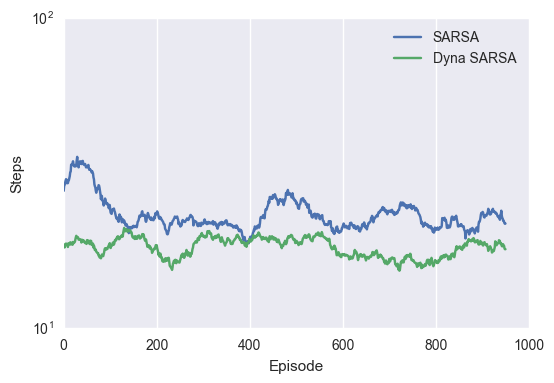

In [113]:
plot_lists([sarsa_steps, dynas_steps], ['SARSA', 'Dyna SARSA'], 'Episode', 'Steps')

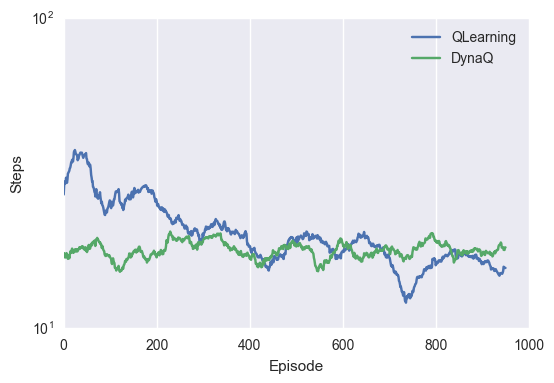

In [114]:
plot_lists([qlearning_steps, dynaq_steps], ['QLearning', 'DynaQ'], 'Episode', 'Steps')

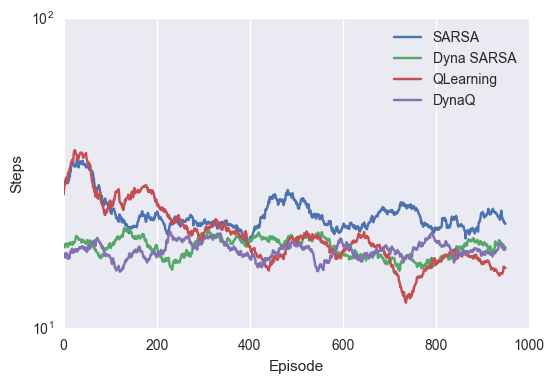

In [115]:
plot_lists([sarsa_steps, dynas_steps, qlearning_steps, dynaq_steps], ['SARSA', 'Dyna SARSA', 'QLearning', 'DynaQ'], 'Episode', 'Steps')

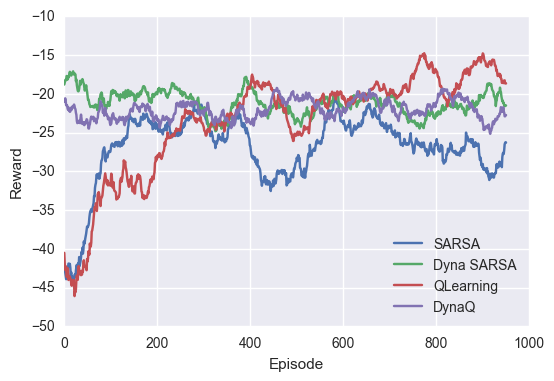

In [116]:
plot_lists([sarsa_rewards, dynas_rewards, qlearning_rewards, dynaq_rewards], ['SARSA', 'Dyna SARSA', 'QLearning', 'DynaQ'], 'Episode', 'Reward', log_scale=False)